In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# To sample the diffusion-weighted directions
from dipy.core.sphere import disperse_charges, Sphere, HemiSphere

# To reconstruct the tables with the acquisition information
from dipy.core.gradients import gradient_table

# To perform the monte-carlo simulations
from dipy.sims.voxel import multi_tensor

# To process the diffusion tensor
import dipy.reconst.dti as dti

# Importing procedures to fit the free water elimination DTI model
from dipy.reconst.fwdti import (wls_fit_tensor, nlls_fit_tensor)

In [2]:
# ---------------------------------------------------------------
# acquisition parameters
# ---------------------------------------------------------------

SNR = 40

# Sample 32 diffusion-weighted directions
n_pts = 32
theta = np.pi * np.random.rand(n_pts)
phi = 2 * np.pi * np.random.rand(n_pts)
hsph_initial = HemiSphere(theta=theta, phi=phi)
hsph_updated, potential = disperse_charges(hsph_initial, 5000)
directions = hsph_updated.vertices # directions for each shell

# Create full dataset parameters
# (6 b-values = 0, 32 directions for each b-values 500 and 1500)
bvals = np.hstack((np.zeros(6), 500 * np.ones(n_pts), 1500 * np.ones(n_pts)))
bvecs = np.vstack((np.zeros((6, 3)), directions, directions))
gtab = gradient_table(bvals, bvecs)
design_matrix = dti.design_matrix(gtab)

In [3]:
# ---------------------------------------------------------------
# Generate simulations
# ---------------------------------------------------------------

# Ground truth values of tissue's diffusion tensor and water volume fraction
FA = np.array([0., 0.11, 0.22, 0.30, 0.71])
L1 = np.array([0.8e-3, 0.900e-3, 1.000e-3, 1.080e-3, 1.6e-03])
L2 = np.array([0.8e-3, 0.763e-3, 0.725e-3, 0.695e-3, 0.5e-03])
L3 = np.array([0.8e-3, 0.738e-3, 0.675e-3, 0.625e-3, 0.3e-03])
VF = np.linspace(0, 100, num=11)
Dwater = 3e-3

nrep = 100  # number of simulation repetitions
DWI_simulates = np.empty((FA.size, VF.size, nrep, bvals.size))

for fa_i in range(FA.size):
    mevals = np.array([[L1[fa_i], L2[fa_i], L3[fa_i]],
                       [Dwater, Dwater, Dwater]])
    for vf_i in range(VF.size):
        fractions = [100 - VF[vf_i], VF[vf_i]]
        for s_i in range(nrep):
            signal, sticks = multi_tensor(gtab, mevals, S0=100, angles=[(0, 0), (0, 0)],
                                          fractions=fractions, snr=SNR)
            DWI_simulates[fa_i, vf_i, s_i, :] = signal 

In [4]:
# ---------------------------------------------------------------
# fit the free water elimination DTI model
# ---------------------------------------------------------------

# WLLS procedures is used to estimate parameters initial guess
fw_params_initial = wls_fit_tensor(design_matrix, DWI_simulates, Diso=Dwater)

In [5]:
fw_params = fw_params_initial.copy()

# NLLS procedures is used to find final parameters guess
fw_params = nlls_fit_tensor(design_matrix, DWI_simulates, 
                            fw_params=fw_params, Diso=Dwater, cholesky=True, f_transform=True)

C:\Users\Rafael\dipy\dipy\reconst\fwdti.py:559: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if fw_params==None:
C:\Users\Rafael\Anaconda\lib\site-packages\scipy\optimize\minpack.py:427: RuntimeWarning: Number of calls to function has reached maxfev = 1800.
  warnings.warn(errors[info][0], RuntimeWarning)


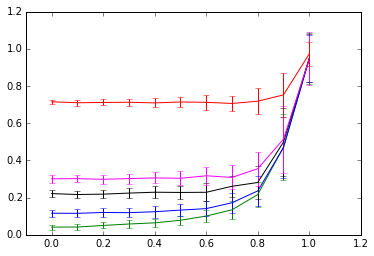

In [7]:
# ---------------------------------------------------------------
# Process diffusion tensor standard measures and plot
# ---------------------------------------------------------------

evals = fw_params[..., :3]
fa = dti.fractional_anisotropy(evals)
f = fw_params[..., 12]

mean_fa = np.empty(VF.size)
std_fa = np.empty(VF.size)

colors = {0: 'g', 1: 'b', 2: 'black', 3: 'magenta', 4: 'r'}

plt.axis([-0.1, 1.2, 0, 1.2])
for fa_i in range(FA.size):
    for vf_i in range(VF.size):
        mean_fa[vf_i] = np.mean(fa[fa_i, vf_i, :])
        std_fa[vf_i] = np.std(fa[fa_i, vf_i, :])
    plt.errorbar(VF/100, mean_fa, yerr=std_fa, color=colors[fa_i],
                 ecolor=colors[fa_i])  
        
plt.show()

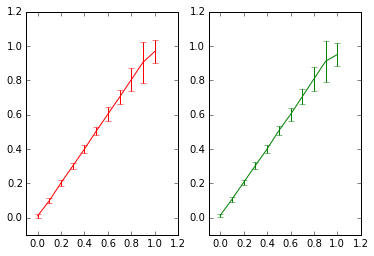

In [8]:
mean_f = np.empty(VF.size)
std_f = np.empty(VF.size)

fig, axs = plt.subplots(nrows=1, ncols=2)
for idx, fa_i in enumerate([4, 0]):
    for vf_i in range(VF.size):
        mean_f[vf_i] = np.mean(f[fa_i, vf_i, :])
        std_f[vf_i] = np.std(f[fa_i, vf_i, :])
    axs[idx].errorbar(VF/100, mean_f, yerr=std_fa, color=colors[fa_i],
                 ecolor=colors[fa_i])
    axs[idx].set_ylim([-0.1, 1.2])
    axs[idx].set_xlim([-0.1, 1.2])